# Mining API Documentation

For users who want to directly access and download mining data created by SkyTruth, and relevant third party data, we provide programmatic free access to an OGC compliant API ([api.mining.skytruth.org](https://api.mining.skytruth.org/)).

For users who are interested in bulk downloads of SkyTruth's MTM datasets, they may also accessed via our [MTM Data Files](https://skytruth.org/mtr-data-files/) page.

For more information about the datasets or the available attributes inside each dataset, please scroll to the end of this doc.

# Example 1: Data Within a Bounding Box

The following examples return data which intersect the bounding box, defined as:

```
?bbox=-81.8156,37.7981,-81.7882,37.8484"
```

## Example 1a: Mine Footprints
First let's grab some example data to play with. This first block is some necessary preamble to enable the other code in this document.

In [ ]:
%%capture
!pip install contextily
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import urllib
import requests
from shapely.geometry import shape

In [ ]:
example_1a_url = (
    "https://api.mining.skytruth.org/collections/public.annual_mining/items?"  # This is the endpoint for annual mining data
    "bbox=-81.8156,37.7981,-81.7882,37.8484"  # This defines the bounding box
    "&limit=50"  # This limits the number of results returned
)
features = requests.get(example_1a_url).json().get("features")  # API response

gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")

gdf.head()

,geometry,area,data_status,id,mining_year
0,"MULTIPOLYGON (((-81.79511 37.79554, -81.79457 ...",201629.560791,final,-303470+140266,1988
1,"MULTIPOLYGON (((-81.79215 37.82114, -81.79188 ...",334286.899048,final,-303473+140357,2015
2,"MULTIPOLYGON (((-81.79215 37.82114, -81.79188 ...",306607.207642,final,-303473+140357,2016
3,"MULTIPOLYGON (((-81.79215 37.82114, -81.79188 ...",295961.132812,final,-303473+140357,2017
4,"MULTIPOLYGON (((-81.79215 37.82114, -81.79188 ...",281056.652832,final,-303473+140357,2018


Now let's make a simple plot tool to visualize these results:

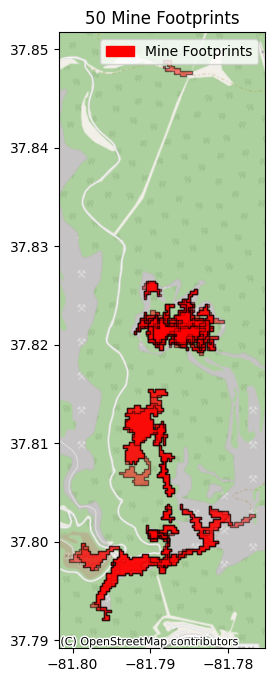

In [ ]:
def simple_plot(
    gdf, label, color="#FF0000", alpha=0.5, edgecolor="#000000", figsize=(12, 8)
):
    _, ax = plt.subplots(figsize=figsize)

    def listy(obj):
        return [obj] if isinstance(obj, str | gpd.GeoDataFrame | float) else list(obj)

    legend_patches, plot_title, first_crs = [], [], None
    for g, lab, col in zip(*map(listy, (gdf, label, color))):
        if g.empty:
            continue
        first_crs = first_crs or g.crs
        g.plot(ax=ax, color=col, label=lab, alpha=alpha, edgecolor=edgecolor)
        legend_patches.append(mpatches.Patch(color=col, label=lab))
        plot_title.append(f"{len(g)} {lab}")

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=first_crs)
    ax.set_title(", ".join(plot_title))
    ax.legend(handles=legend_patches)


simple_plot(gdf, label="Mine Footprints")

## Example 1b: Mine Permits
This example returns WV Permit data which intersect the bounding box.

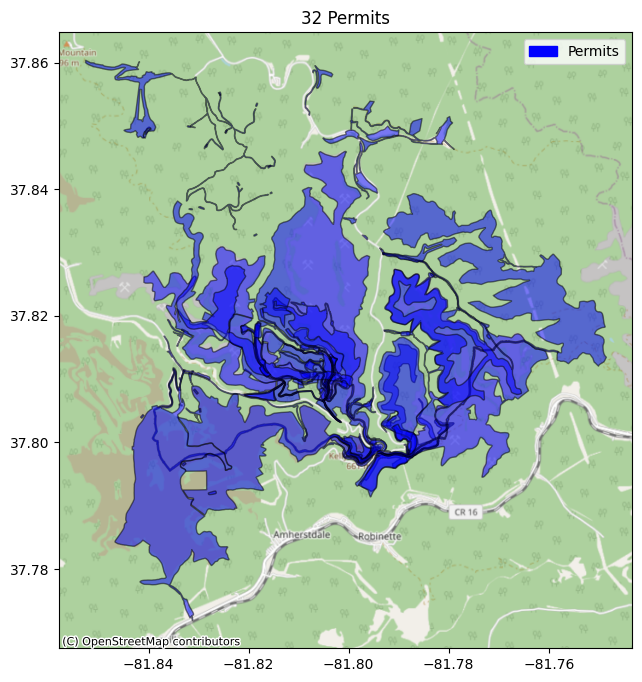

In [ ]:
example_1b_url = (
    "https://api.mining.skytruth.org/collections/public.state_permits_wv/items?"  # This is the endpoint for state permit data
    "bbox=-81.8156,37.7981,-81.7882,37.8484"  # This defines the bounding box
    "&limit=50"  # This limits the number of results returned
)
features = requests.get(example_1b_url).json().get("features")
gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
simple_plot(gdf, label="Permits", color="Blue")

## Example 1c: Return Highwalls

In [ ]:
example_1c_url = (
    "https://api.mining.skytruth.org/collections/public.highwall_detections/items?"  # This is the endpoint for highwall centerline data
    "bbox=-81.8156,37.7981,-81.7882,37.8484"  # This defines the bounding box
    "&limit=50"  # This limits the number of results returned
)
features = requests.get(example_1c_url).json().get("features")
if not features:
    print("Coming soon! Highwall data is not yet available for this region.")
else:
    gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
    simple_plot(gdf, label="Highwalls", color="Black")


Coming soon! Highwall data is not yet available for this region.


# Example 2: Results based on Intersections with other Datasets

## Example 2a: Mine Footprints Given a Permit ID
This example returns mining footprints which intersect a permit that has been specified by permit_id. This example filters out any mine footprints which are provisional.

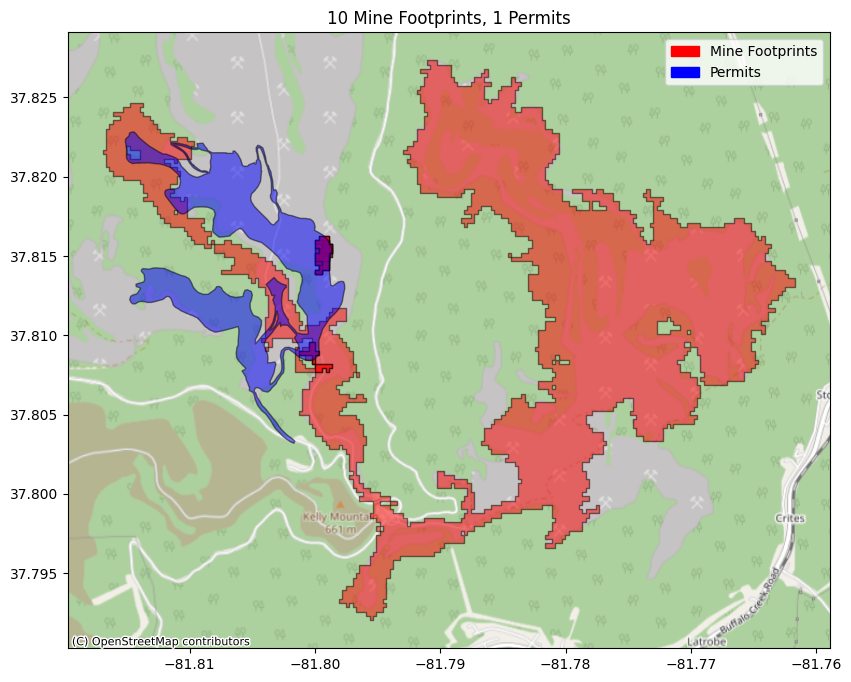

In [ ]:
example_2a_permit_url = (
    "https://api.mining.skytruth.org/collections/public.state_permits_wv/items?"  # This is the endpoint for state permit data
    "permit_id=S501889"  # This specifies a Permit, by permit_id
)
permit_features = requests.get(example_2a_permit_url).json().get("features")
permit_gdf = gpd.GeoDataFrame.from_features(permit_features, crs="EPSG:4326")
geom = shape(permit_gdf["geometry"][0])


example_2a_mine_url = (
    "https://api.mining.skytruth.org/collections/public.annual_mining/items?"  # This is the endpoint for annual mine data
    f"filter=s_intersects(geom,{geom}) AND data_status NE 'provisional'"  # This removes provisional data and finds the intersection with permit data returned by the permit_url, using CQL2 text
)
mine_features = requests.get(example_2a_mine_url).json().get("features")
mine_gdf = gpd.GeoDataFrame.from_features(mine_features, crs="EPSG:4326")

simple_plot([mine_gdf, permit_gdf], ["Mine Footprints", "Permits"], ["Red", "Blue"])

## Example 2b - Mine Footprints Given a Mine Name
This example returns mining footprints which intersect a permit that has been specified by mine_name (facility name). This example filters out any mine footprints which are provisional.

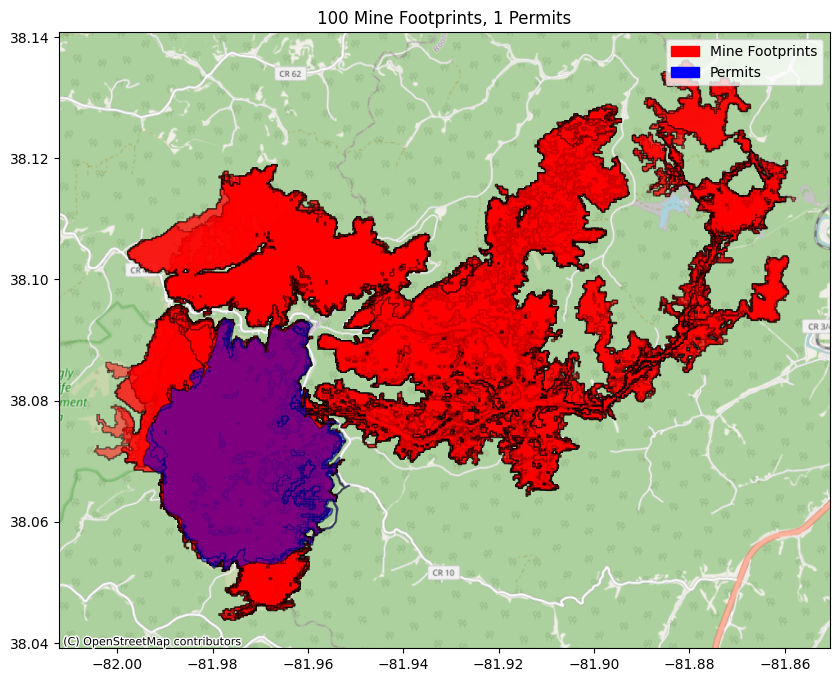

In [ ]:
example_2b_permit_url = (
    "https://api.mining.skytruth.org/collections/public.state_permits_wv/items?"  # This is the endpoint for state permit data
    "mine_name=HOBET 21 WEST RIDGE SURFACE"  # This specifies a Permit, by mine name
)
permit_features = requests.get(example_2b_permit_url).json().get("features")
permit_gdf = gpd.GeoDataFrame.from_features(permit_features, crs="EPSG:4326")
permit_geom = shape(permit_gdf["geometry"][0])

example_2b_mine_url = (
    "https://api.mining.skytruth.org/collections/public.annual_mining/items?"  # This is the endpoint for annual mine data
    f"filter=s_intersects(geom,{permit_geom}) AND data_status NE 'provisional'"  # This removes provisional data and finds the intersection with permit data returned by the permit_url
    "&limit=100"
)
mine_features = requests.get(example_2b_mine_url).json().get("features")
mine_gdf = gpd.GeoDataFrame.from_features(mine_features, crs="EPSG:4326")

simple_plot([mine_gdf, permit_gdf], ["Mine Footprints", "Permits"], ["Red", "Blue"])

## Example 2c: Permits Given a Mine ID
This example returns state permits which intersect a mining footprint that has been specified by id.

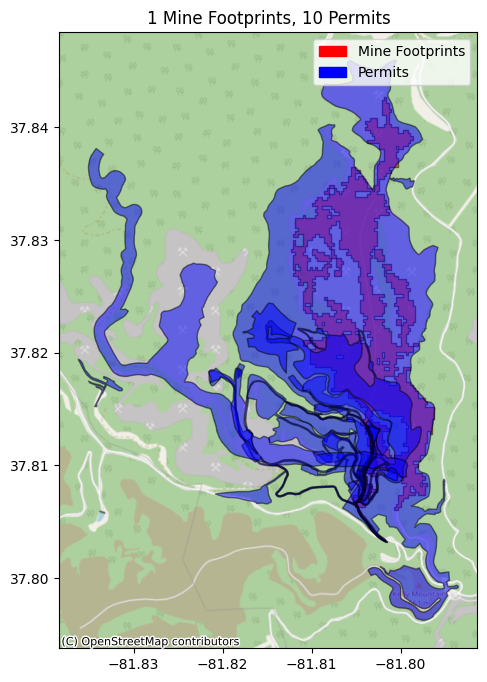

In [ ]:
# mine_id output from EE is not URL safe--it must be URL encoded.
mine_id = "-303538+140420"

example_2c_mine_url = (
    "https://api.mining.skytruth.org/collections/public.annual_mining/items?"  # This is the endpoint for annual mining data
    f"id={urllib.parse.quote(mine_id)}"  # This specifies a mine footprint, by id
)
mine_features = requests.get(example_2c_mine_url).json().get("features")
mine_gdf = gpd.GeoDataFrame.from_features(mine_features, crs="EPSG:4326")
mine_geom = shape(mine_gdf["geometry"][0])

example_2c_permit_url = (
    "https://api.mining.skytruth.org/collections/public.state_permits_wv/items?"  # This is the endpoint for state permit data
    f"filter=s_intersects(geom,{mine_geom})"  # This finds the intersection with mine fooprint data returned by the mine_url
)
permit_features = requests.get(example_2c_permit_url).json().get("features")
permit_gdf = gpd.GeoDataFrame.from_features(permit_features, crs="EPSG:4326")

simple_plot([mine_gdf, permit_gdf], ["Mine Footprints", "Permits"], ["Red", "Blue"])

## Example 2d: Return Highwalls Given a Permit
This example returns highwall centerlines which intersect a state permit that has been specified by permit_id.

In [ ]:
example_2d_permit_url = (
    "https://api.mining.skytruth.org/collections/public.state_permits_wv/items?"  # This is the endpoint for state permit data
    "permit_id=S501889"  # This specifies a Permit, by permit_id
)
permit_features = requests.get(example_2d_permit_url).json().get("features")
permit_gdf = gpd.GeoDataFrame.from_features(permit_features, crs="EPSG:4326")
permit_geom = shape(permit_gdf["geometry"][0])

example_2d_highwall_url = (
    "https://api.mining.skytruth.org/collections/public.ADD_HIGHWALL_NAME_WHEN_FINAL/items?"  # This is the endpoint for annual mining data
    f"filter=s_intersects(geom,{permit_geom})"  # This finds the intersection with permit data returned by the permit_url
)
highwall_features = requests.get(example_2d_highwall_url).json().get("features")
if highwall_features:
    highwall_gdf = gpd.GeoDataFrame.from_features(highwall_features, crs="EPSG:4326")
    simple_plot([highwall_gdf, permit_gdf], ["Highwalls", "Permits"], ["Black", "Blue"])
else:
    print("Coming soon! Highwall data is not yet available for this region.")

Coming soon! Highwall data is not yet available for this region.


# Other Examples

## Example 3: Downloading Data
Download data using curl, as geojson

In [ ]:
example_3_url = (
    "https://api.mining.skytruth.org/collections/public.annual_mining/items?"  # This is the endpoint for annual mining data
    "bbox=-81.8156,37.7981,-81.7882,37.8484"  # This defines the bounding box
    "&limit=50"  # This limits the number of results returned
)

!curl "{example_3_url}" -o /content/example_3.geojson # download the geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   213k      0 --:--:-- --:--:-- --:--:--  213k


## Example 4: Viewing e-AMLIS within a bounding box
Visualize data from the OSMRE's e-AMLIS database. This is data that has been downloaded and hosted by SkyTruth, last updated on 2025/10/24, and therefore may not be as up-to-date as data accessed directly from the [e-AMLIS](https://amlis.osmre.gov/) site.

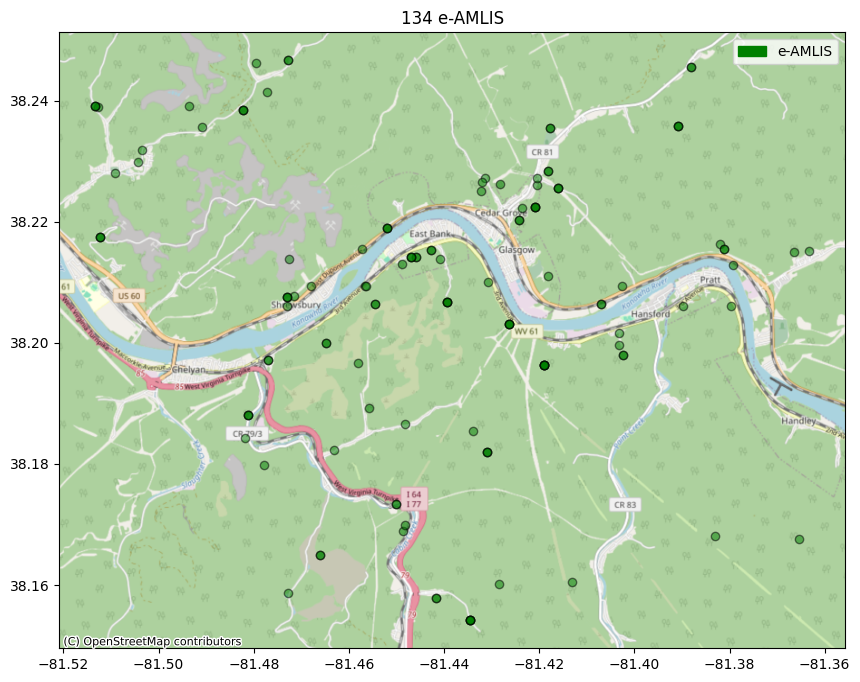

In [ ]:
example_4_url = (
    "https://api.mining.skytruth.org/collections/public.eamlis/items"  # This is the endpoint for annual mining data
    "?bbox=-81.515,38.154,-81.363,38.250"  # This defines the bounding box
    "&limit=500"  # This limits the number of results returned
)
features = requests.get(example_4_url).json().get("features")
gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
simple_plot(gdf, label="e-AMLIS", color="Green")

# Additional Notes

## How to Cite
SkyTruth Mining API. Query: [Brief description of your query]. Retrieved [YYYY/MM/DD] from https://api.mining.skytruth.org



## Sources
We currently provide the following datasets:

*SkyTruth Datasets*
1. Annual Mining Footprints 1985-2025 (SkyTruth); [see: public.annual_mining](https://api.mining.skytruth.org/collections/public.annual_mining/items)

2. Highwall Detections (SkyTruth); COMING SOON


*Non-SkyTruth Datasets*
1. County Boundaries (US Census Bureau); [see: public.counties](https://api.mining.skytruth.org/collections/public.counties/items)


2. HUC Bouundaries (2-12) (USGS);  [see: public.huc_boundaries](https://api.mining.skytruth.org/collections/public.huc_boundaries/items)

3. Abandoned Mine Land Inventory System - Problem Areas (OSMRE); [see: public.eamlis](https://api.mining.skytruth.org/collections/public.eamlis/items)

4. State Permit Data, is filtered to SkyTruth's Central Appalachian Study Area. Separate tables are provided for each state. Permit data was accessed from state mining permit databases, Freedom of Information Act (FOIA) requests to state and federal agencies, and the [OSMRE GeoMine database](https://geomine.osmre.gov/).
    - **Kentucky**; [see: public.state_permits_ky](https://api.mining.skytruth.org/collections/public.state_permits_ky/items)
      - KY Permit Data Source: (KyGovMaps Open Data Portal)[https://opengisdata.ky.gov/datasets/kygeonet::ky-permitted-mine-boundaries/about]
    - **Tennessee**; [see: public.state_permits_tn](https://api.mining.skytruth.org/collections/public.state_permits_tn/items)
      - TN Permit Data Source: (OSMRE GeoMine)[https://geomine.osmre.gov/]
    - **Virginia**; [see: public.state_permits_va](https://api.mining.skytruth.org/collections/public.state_permits_va/items)
        - VA Permit Data Source: (Virgian Department of Energy)[https://energy.virginia.gov/webmaps/MinedLandRepurposing/]
    - **West Virginia**; [see: public.state_permits_wv](https://api.mining.skytruth.org/collections/public.state_permits_wv/items)
      - WV Permit Data Source: (WVDEP)[https://tagis.dep.wv.gov/home/gis%20data]; with additional permit data accessed via (WVDEP Permit Search)[https://dep.wv.gov/dmr/Pages/PermitSearch.aspx]


Please note:
- Permit Data is provided on a state-by-state basis, with separate tables for data from each state. There may be some consistency between data attributes across states, but is not guarenteed.


## Third Party Data
[Abandoned Mine Land Inventory System (e-AMLIS)](https://amlis.osmre.gov/) Data was accessed on 2025/10/24.


[Watershed Boundary Dataset (WBD)](https://www.usgs.gov/national-hydrography/access-national-hydrography-products) was accessed on 2025/11/06. Data was then filtered to include only records which intersect the Central Appalachian study area (the area for which annual mining data is available).
- [Data Source](https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/Hydrography/WBD/National/GPKG/)
- An issue exists where some HUC Boundaries share the same `objectid` attribute, we create `st_id` to be used as a uniqe identifier for the data accessible via the API. `st_id` is a string, whose value is a equal to `object_id + "_" + row_number`

County Boundary Data was accessed from the [United States Census Bureau's TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) on 2025/11/06. Data was then filtered to include only records which intersect the Central Appalachian study area (the area for which annual mining data is available).
- [Data Source](https://www2.census.gov/geo/tiger/TIGER2025/COUNTY/)

## Filters
- Bounding boxes are declared using the format: min_x, min_y, max_x, max_y (which can be thought of alternatively as: Lower-Left-X, Lower-Left-Y, Upper-Right-X, Upper-Right-Y or Lower-Left-Lon, Lower-Left-Lat, Upper-Right-Lon, Upper-Right-Lat)
  - For the following examples, this bounding box is within the sample counties. bbox_coords="-81.8156,37.7981,-81.7882,37.8484"

- A limit parameter can be used to limit the number of results returned by a query.

- Mine footprints can be filtered based on their data_status; `provisional` data is provided for the most recent yearly
footprint available, `final` data are yearly footprints which have been fully cleaned.
  - ex. `"filter": "data_status!='provisional'"` will remove provisional data


# GLOSSARY

## public.counties

|Attribute Name|Description|
|-|-|
|**geom**| A polygon representing a county's boundary|
|**aland**| Current land area|
|**awater**| Current water area|
|**cbsafp**| Current metropolitan statistical area/micropolitan statistical area code|
|**classfp**| Current Federal Information Processing Series (FIPS) class code|
|**countyfp**| Current county Federal Information Processing Series (FIPS) code|
|**countyns**| Current county GNIS code|
|**csafp**| Current combined statistical area code|
|**funcstat**| Current functional status|
|**geoid**| ounty identifier; a concatenation of Current state FIPS code and county FIPS code|
|**geoidfq**| Fully qualified county identifier; a concatenation of census survey summary level information with the county identifier. The GEOIDFQ attribute is calculated to facilitate joining census spatial data to census survey summary files.|
|**intptlat**| Current latitude of the internal point|
|**intptlon**| Current longitude of the internal point|
|**lsad**| Current legal/statistical area description code for county|
|**metdivfp**| Current metropolitan division code|
|**mtfcc**| MAF/TIGER feature class code|
|**name**| Current county name|
|**namelsad**| Current name and the translated legal/statistical area description for county|
|**statefp**| Current state Federal Information Processing Series (FIPS) code|

## public.annual_mining
|Attribute Name|Description|
|-|-|
|**geom**| A polygon representing a mine footprint's extent|
|**area**| The area of the footprint, in square meters|
|**data_status**| Data status, can be `final` or `provisional`|
|**id**| ID, a unique ID for each mine footprint|
|**mining_year**| Mining Year, the year the footprint was detected|



## public.highwall_detections -- COMING SOON!
|Attribute Name|Description|
|-|-|
|**geom**| Polygon representing the highwall detection|
|**highwall_id**| Unique ID of highwall|
|**rec_status**| Reclamation status of highwall, determined by visual interpretation of most recent available high-resolution imagery|
|**rec_status_yr**| Source year of most recent available high-resolution imagery|
|**earliest_vis_yr**| Source year of high-resolution imagery in which highwall is first visible|
|**first_mined_yr**| First year highwall was mined, calculated as the year after which 75% of pixels within highwall geometry were first detected as mined|
|**last_mined_yr**| Last year highwall was mined, calculated as the year before which 75% of pixels within highwall geometry were last detected as mined|
|**max_age**| Maximum age of highwall, calculated as (2025 - First_Mined_Yr)|
|**min_age**| Minimum age of highwall, calculated as (Rec_Status_Yr - Earliest_Vis_Yr)|
|**mid_age**| Midpoint age of highwall, calculated as (Max_Age + Min_Age) / 2|
|**age_uncertainty**| Uncertainty in highwall age, calculated as (Max_Age - Min_Age) / 2|
|**lidar_project**| Name of state lidar aquisition project|
|**lidar_yr**| Source year of lidar data|
|**mean_slope**| Mean slope within highwall geometry, calculated from 10m DEM (used for highwall classification purposes only)|
|**med_slope**| Median slope within highwall geometry, calculated from 10m DEM (used for highwall classification purposes only)|
|**max_slope**| Maximum slope within highwall geometry, calculated from 10m DEM (used for highwall classification purposes only)|
|**all_permit_ids**| List of permit IDs for all mining permits that intersect highwall|
|**segment_id**| Unique ID of segment|
|**raw_length**| Length of unsimplified segment centerline|
|**length**| Lenth of simplified segment centerline, used as official length value for all further calculations|
|**base_elevation**| Elevation of base of highwall segment, calculated as 10th percentile elevation value within segment geometry|
|**top_elevation**| Elevation of top of highwall segment, calculated as 90th percentile elevation value within segment geometry|
|**height**| Height of highwall segment, calculated as (Top_Elevation - Base_Elevation)|
|**min_cost**| Minimum cost to backfill and regrade highwall segment, calculated at $1.25 per cubic yard|
|**mid_cost**| Mid-range cost to backfill and regrade highwall segment, calculated at $1.875 per cubic yard|
|**max_cost**| Maximum cost to backfill and regrade highwall segment, calculated at $2.50 per cubic yard|
|**permit_id**| Permit ID of associated permit|
|**state**| State in which highwall and its associated permit are located|
|**permittee**| Permittee name|
|**mine_name**| Name of mine or operation|
|**mine_status**| Specific mine status description|
|**bond_status**| Standardized bond status|
|**avail_bond**| Bond funds available for highwall reclamation; does not include bonds for permits in Phase 1 or 2 release|
|**full_bond**| Bond funds available for all reclamation; includes bonds for permits in Phase 1 or 2 release|

## public.eamlis
See: [e-AMLIS Data Dictionary](https://web.archive.org/web/20150905121040/http://www.osmre.gov/programs/AMLIS/dictionary.shtm)for full documentation. Example fields include:
|Attribute Name|Description|
|-|-|
|**geom**| A polygon representing a highwall's length|
|**objectid**| Object ID|
|**amlis_key**| AMLIS Key, A value assigned to a problem area description that contains a States or Tribes abbreviation followed by six integers that are either auto generated or manually assigned.|
|**state_key**| State Key|
|**pa_number**| PA Number|
|**pa_name**| PA Name, The name that is given to a problem area by a State or Tribe.|
|**pu_number**| PU Number, A number that is auto generated when a State or Tribe establishes a Planning Unit. Planning Units are subdivision(s) of Water Cataloging Units (WCU) established by the Water Resources Council.|
|**pu_name**| PU Name, A name that is assigned by a State or Tribe when they establish a Planning Unit. Planning Units are subdivision(s) of Water Cataloging Units (WCU) established by the Water Resources Council.|
|**county**| County Name|
|**fips_code**| FIPS Code|
|**quad_name**| Quad Name|
|**huc_code**| HUC Code|
|**watershed**| Watershed Name|
|**mine_type**| Mine type|
|**ore_types**| Ore types|


## public.state_permits_ky
|Attribute Name|Description|Source|
|-|-|-|
|permit_id|KY Permitted Mine Boundaries|
|feat_cls|Permit ID number|KY Permitted Mine Boundaries|
|source|Type of mine (SF = surface, UG = underground)|KY Permitted Mine Boundaries|
|type_flag|Source of spatial boundary data|KY Permitted Mine Boundaries|
|acres|ACT = Active (mines with a valid permit only, does not mean that the mine is actively producing coal). INACT = Inactive (reclaimed, forfeited, or abandoned). RECNF = Record Not Found (mining of some sort occurred at this location but before records were kept starting in 1977 with SMCRA).|KY Permitted Mine Boundaries|
|quadrangle|Calculated acreage of permit|KY Permitted Mine Boundaries|
|status_code1|USGS quadrangle name|KY Permitted Mine Boundaries|
|permittee1|Two-letter mine status code|KY Permitted Mine Boundaries|
|region|Permittee name|KY Permitted Mine Boundaries|
|activity|Region name|KY Permitted Mine Boundaries|
|act_rel|Permit activity (application type, date issued, and sequence)|KY Permitted Mine Boundaries|
|issue_date|Active or Released|KY Permitted Mine Boundaries|
|orig_id|Issue date|KY Permitted Mine Boundaries|
|national_id|Original permit ID number|KY Permitted Mine Boundaries|
|shape_length|National permit ID number, consists of "KY" + permit_id|KY Permitted Mine Boundaries|
|per_type|Shape length|KY Permitted Mine Boundaries|
|shape_area|Permit type in relation to SMCRA: Permanent, Interim, or Pre Law|KY Permitted Mine Boundaries|
|permittee2|Shape area|Bond FOIA|
|status_code2|Permittee name|Bond FOIA|
|status_desc|Two-letter mine status code|Bond FOIA|
|inspectable|Status description|Bond FOIA|
|curr_bond|Inspectable unit status (YES/NO)|Bond FOIA|
|orig_bond|Current bond amount (USD)|Bond FOIA|
|highwall_total|Original bond amount (USD)|State Highwall Length Tracking Data|
|highwall_comp|Total open highwall, as recorded by state inspectors (feet)|State Highwall Length Tracking Data|
|highwall_viol|Highwall in compliance, as recorded by state inspectors (feet)|State Highwall Length Tracking Data|
|permittee3|Highwall under violation, as recorded by state inspectors (feet)|GeoMine|
|mine_name|Permittee name|GeoMine|
|post_smcra|Name of mine, operation, or facility|GeoMine|
|op_status|Post-SMCRA status (1/0)|GeoMine|
|gm_bond_status|Coalmine operation status|GeoMine|
|prep_ref|Bond status|Prep plant / refuse impoundment dataset|
|avail_bond|Prep plant or refuse impoundment (Y/N)|derived from Bond FOIA|
|full_bond|Bond funds available for backfilling and grading; does not include bonds for permits in Phase I or II release (USD)|derived from Bond FOIA|
|permittee|Bond funds available for all reclamation; includes bonds for permits in Phase I or II release (USD)|derived from Bond FOIA, KY Permitted Mine Boundaries and GeoMine|
|mine_status|Permitte name, compiled across sources|derived from Bond FOIA, KY Permitted Mine Boundaries and GeoMine|
|bond_status|Specific mine status description, compiled across sources|derived from Bond FOIA and GeoMine|
|surf_mine|Standardized bond status (Bonded, Forfeited, Released, or Not Bonded), compiled across sources|derived from KY Permitted Mine Boundaries and prep plant / refuse impoundment dataset|


## public.state_permits_tn
|Attribute Name|Description|Source|
|-|-|-|
|permittee|Permittee name|TN Permit Boundaries (GeoMine)|
|op_status|Coalmine operation status|TN Permit Boundaries (GeoMine)|
|mine_name|Name of mine, operation, or facility|TN Permit Boundaries (GeoMine)|
|permit_id|Permit ID number|TN Permit Boundaries (GeoMine)|
|msha_id|Mine Safety and Health Administration ID|TN Permit Boundaries (GeoMine)|
|national_id|National ID|TN Permit Boundaries (GeoMine)|
|coal_beds|Coal bed name(s)|TN Permit Boundaries (GeoMine)|
|inspectable|Inspectable unit status|TN Permit Boundaries (GeoMine)|
|post_smcra|Post-SMCRA status|TN Permit Boundaries (GeoMine)|
|acres|Calculated area of permit|TN Permit Boundaries (GeoMine)|
|issue_date|Permit application approval date|TN Permit Boundaries (GeoMine)|
|edit_date|State/tribe defined edit date|TN Permit Boundaries (GeoMine)|
|area|Area mining (1/0)|TN Permit Boundaries (GeoMine)|
|contour|Contour mining (1/0)|TN Permit Boundaries (GeoMine)|
|mtntop|Mountaintop mining (1/0)|TN Permit Boundaries (GeoMine)|
|steepslope|Steep slope mining (1/0)|TN Permit Boundaries (GeoMine)|
|highwall|Highwall mining (1/0)|TN Permit Boundaries (GeoMine)|
|auger|Auger mining (1/0)|TN Permit Boundaries (GeoMine)|
|comment|Comment|TN Permit Boundaries (GeoMine)|
|contact|Contact|TN Permit Boundaries (GeoMine)|
|info|Information hyperlink|TN Permit Boundaries (GeoMine)|
|bond_type|Bond type|Bond FOIA and OSMRE Shortfall Data|
|status|Bond / mine status|Bond FOIA|
|bond_amount|Bond amount (USD)|OSMRE shortfall data|
|land_req_bond|Required land reclamation bond, as calculated by OSMRE (USD)|OSMRE shortfall data|
|water_req_bond|Required water reclamation bond, as calculated by OSMRE (USD)|OSMRE shortfall data|
|total_req_bond|Total required reclamation bond, as calculated by OSMRE (USD)|OSMRE shortfall data|
|shortfall|Shortfall between posted bond and required bond, as calculated by OSMRE (USD)|OSMRE shortfall data|
|notes|Notes|OSMRE shortfall data|
|prep_ref|Prep plant or refuse impoundment|Prep plant / refuse impoundment dataset|
|avail_bond|Bond funds available for highwall reclamation; does not include bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA and OSMRE shortfall data|
|full_bond|Bond funds available for all reclamation; includes bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA and OSMRE shortfall data|
|gm_bond_status|Bond status|GeoMine|
|mine_status|Specific mine status description|derived from Bond FOIA, OSMRE Shortfall Data, and TN Permit Boundaries (GeoMine)|
|bond_status|Standardized bond status (Bonded, Forfeited, Released, or Not Bonded)|derived from Bond FOIA, OSMRE Shortfall Data, and GeoMine|
|surf_mine|Surface mine (1) or anything else - underground mine, prep plant refuse impoundement, tibble, etc. (0)|derived from Prep plant / refuse impoundment dataset|


## public.state_permits_va
|Attribute Name|Description|Source|
|-|-|-|
|permit_id|Permit ID number|VA Permit Boundaries|
|permittee|Permittee name|VA Permit Boundaries|
|release_date|Release date|VA Permit Boundaries|
|trans_from|Permit ID number from which this permit was transferred|VA Permit Boundaries|
|comment|Comment|VA Permit Boundaries|
|acres|Acreage of permit|VA Permit Boundaries|
|permit_type|Permit type code|VA Permit Boundaries|
|global_id|Global ID|VA Permit Boundaries|
|created_user|Initials of user who created data entry|VA Permit Boundaries|
|created_date|Date of data entry|VA Permit Boundaries|
|last_edit_user|Initials of user who last edited data entry|VA Permit Boundaries|
|last_edit_date|Date of last edit of data entry|VA Permit Boundaries|
|st_area|Shape area|VA Permit Boundaries|
|st_length|Shape length|VA Permit Boundaries|
|bond_code|Bond release status (Phase 1, 2, or 3)|VA Permit Boundaries|
|app_no|Permit application number|VA Permit Boundaries|
|permittee_code|Permittee code|VA Permit Boundaries|
|operation|Operation name|VA Permit Boundaries|
|county|County|VA Permit Boundaries|
|seams|Coal seams|VA Permit Boundaries|
|quads|Quads|VA Permit Boundaries|
|mine_types|Mine types|VA Permit Boundaries|
|permit_status|Permit status code|VA Permit Boundaries|
|permit_status_date|Permit status date|VA Permit Boundaries|
|orig_issue|Original issue date|VA Permit Boundaries|
|anniversary|Anniversary date|VA Permit Boundaries|
|bond_type|Bond type (C = full cost, P = pool)|VA Permit Boundaries|
|remining|Remining (Y/N)|VA Permit Boundaries|
|remining_acres|Area of remining (acres)|VA Permit Boundaries|
|underground|Underground mining (Y/N)|VA Permit Boundaries|
|mtntop|Mountaintop mining (Y/N)|VA Permit Boundaries|
|steepslope|Steep slope variance (Y/N)|VA Permit Boundaries|
|auger|Auger mining (Y/N)|VA Permit Boundaries|
|non_aoc|Non-AOC variance (Y/N)|VA Permit Boundaries|
|tbl_os_code|Operating status code|VA Permit Boundaries|
|tbl_os_desc|Operating status description|VA Permit Boundaries|
|pe_os_date|Permit operating status date|VA Permit Boundaries|
|rec_status|Reclamation status (dis = disturbed, reg = regraded, veg = vegetated)|VA Permit Boundaries|
|layer|Source layer of feature|derived from VA Permit Boundaries|
|gm_mine_name|Name of mine, operation, or facility|GeoMine|
|post_smcra|Post-SMCRA status|GeoMine|
|op_status|Coalmine operation status|GeoMine|
|gm_bond_status|Bond status|GeoMine|
|app_date|Permit application approval date|GeoMine|
|prep_ref|Prep plant or refuse impoundment|Prep plant / refuse impoundment dataset|
|bond_method|Bond method (C = full cost, P = pool)|Bond FOIA|
|permitted_acres|Permitted acres|Bond FOIA|
|bonded_acres|Bonded acres|Bond FOIA|
|bond_amount|Bond amount|Bond FOIA|
|mine_name|Name of mine, operation, or facility|derived from VA Permit Boundaries and GeoMine|
|mine_status|Specific mine status description|derived from VA Permit Boundaries and GeoMine|
|bond_status|Standardized bond status (Bonded, Forfeited, Released, or Not Bonded)|derived from VA Permit Boundaries and Bond FOIA|
|issue_date|Issue date|derived from VA Permit Boundaries and GeoMine|
|surf_mine|Surface mine (1) or anything else - underground mine, prep plant refuse impoundement, tibble, etc. (0)|derived from VA Permit Boundaries and Prep plant / refuse impoundment dataset|
|full_bond|Bond funds available for all reclamation; includes bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA|
|avail_bond|Bond funds available for highwall reclamation; does not include bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA|


## public.state_permits_wv
|Attribute Name|Description|Source|
|-|-|-|
|permit_id|Permit ID number|WV Permit Boundaries|
|map_date|Map date|WV Permit Boundaries|
|map_type|Map type|WV Permit Boundaries|
|active_vio|Active violations|WV Permit Boundaries|
|total_vio|Total violations|WV Permit Boundaries|
|mine_name|Name of mine, operation, or facility|WV Permit Boundaries|
|acres_orig|Original acreage|WV Permit Boundaries|
|acres_curr|Current acreage|WV Permit Boundaries|
|acres_dist|Disturbed acreage|WV Permit Boundaries|
|acres_recl|Reclaimed acreage|WV Permit Boundaries|
|mstatus|Mine status code|WV Permit Boundaries|
|mdate|Mine status date|WV Permit Boundaries|
|issue_date|Issue date|WV Permit Boundaries|
|expir_date|Expiration date|WV Permit Boundaries|
|permittee|Permittee name|WV Permit Boundaries|
|operator|Operator name|WV Permit Boundaries|
|last_update|Date of last update|WV Permit Boundaries|
|comments|Comments|WV Permit Boundaries|
|pstatus|Permit status code|WV Permit Boundaries|
|area|Area mining (Y/N)|WV Permit Boundaries|
|contour|Contour mining (Y/N)|WV Permit Boundaries|
|mtntop|Mountaintop mining (Y/N)|WV Permit Boundaries|
|steepslope|Steep slope mining (Y/N)|WV Permit Boundaries|
|auger|Auger mining (Y/N)|WV Permit Boundaries|
|room_pillar|Room and pillar mining (Y/N)|WV Permit Boundaries|
|longwall|Longwall mining (Y/N)|WV Permit Boundaries|
|refuse|Refuse (Y/N)|WV Permit Boundaries|
|loadout|Loadout facility (Y/N)|WV Permit Boundaries|
|prep_plant|Prep plant (Y/N)|WV Permit Boundaries|
|haul_road|Haul road (Y/N)|WV Permit Boundaries|
|rockfill|Rockfill (Y/N)|WV Permit Boundaries|
|impoundment|Impoundment (Y/N)|WV Permit Boundaries|
|tipple|Tipple (Y/N)|WV Permit Boundaries|
|pmlu1|Primary post-mining land use|WV Permit Boundaries|
|pmlu2|Secondary post-mining land use|WV Permit Boundaries|
|weblink|Link to permit record in online database|WV Permit Boundaries|
|st_area|Shape area|WV Permit Boundaries|
|st_length|Shape length|WV Permit Boundaries|
|status_desc|Mine status description|Bond FOIA|
|permit_status|Permit status code|Bond FOIA|
|bond_amount|Bond amount (USD)|Bond FOIA|
|type|Type of mine or operation|Permit Search|
|current_status|Current status|Permit Search|
|post_smcra|Post-SMCRA status|GeoMine|
|op_status|Coalmine operation status|GeoMine|
|gm_bond_status|Bond status|GeoMine|
|prep_ref|Prep plant or refuse impoundment|Prep plant / refuse impoundment dataset|
|avail_bond|Bond funds available for highwall reclamation; does not include bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA|
|full_bond|Bond funds available for all reclamation; includes bonds for permits in Phase 1 or 2 release (USD)|derived from Bond FOIA|
|mine_status|Specific mine status description|derived from Bond FOIA, Permit Search, and WV Permit Boundaries|
|bond_status|Standardized bond status (Bonded, Forfeited, Released, or Not Bonded)|derived from Bond FOIA and GeoMine|
|surf_mine|Surface mine (1) or anything else - underground mine, prep plant refuse impoundement, tibble, etc. (0)|derived from WV Permit Boundaries and Prep plant / refuse impoundment dataset|
